In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Sentime

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Sentime


In [50]:
data = pd.read_csv('2020_04_27_dataset.csv')
test_data = pd.read_csv('2020_04_26_dataset.csv')

data = data[data['sentiment'] != 'NEUTRAL']
data = data[data['sentiment'] != 'MIXED']

test_data = test_data[test_data['sentiment'] != 'NEUTRAL']
test_data = test_data[test_data['sentiment'] != 'MIXED']

# remove emojis
data['tweet'] = data['tweet'].apply(lambda s: s.encode('ascii', 'ignore').decode('ascii'))
test_data['tweet'] = test_data['tweet'].apply(lambda s: s.encode('ascii', 'ignore').decode('ascii'))

# data['tweet'] = data['tweet'].apply(lambda x: re.sub(r'pic.twitter\S+', '', x))
# data['tweet'] = data['tweet'].apply(lambda x:re.sub(r'https?:\/\/.*[\r\n]*', '', x))
# data['tweet'] = data['tweet'].apply(lambda x:re.sub(r'@[A-Za-z0-9]+', '', x))
# data['tweet'] = data['tweet'].apply(lambda x: x.lower())
# "".join([char for char in text if char != string.punctuation and char != '\n' and char != '\r']).strip()

print(data['sentiment'].value_counts())
print(test_data['sentiment'].value_counts())

POSITIVE    9959
NEGATIVE    6123
Name: sentiment, dtype: int64
POSITIVE    167
NEGATIVE    119
Name: sentiment, dtype: int64


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Embedding
max_features = 20000
maxlen = 140
embedding_size = 128

tokenizer = Tokenizer(num_words=max_features, split=' ')

tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X, maxlen=maxlen)

tokenizer.fit_on_texts(test_data['tweet'].values)
X_test = tokenizer.texts_to_sequences(test_data['tweet'].values)
X_test = pad_sequences(X_test, maxlen=maxlen)

Y = np.zeros(data['sentiment'].shape[0])
Y[data['sentiment'] == 'POSITIVE'] = 1

y_test = np.zeros(test_data['sentiment'].shape[0])
y_test[test_data['sentiment'] == 'POSITIVE'] = 1

# from sklearn.preprocessing import LabelBinarizer
# from keras.utils import to_categorical

# lb = LabelBinarizer()
# Y = lb.fit_transform(data['sentiment'])
# Y = to_categorical(Y)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14473, 140) (14473,)
(286, 140) (286,)


In [43]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(1))
model.add(Activation('sigmoid'))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 140, 128)          2560000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 140, 128)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 136, 64)           41024     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 34, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 71        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [37]:
# Training
batch_size = 30
epochs = 3

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12865 samples, validate on 3217 samples
Epoch 1/3
12865/12865 [==============================] - 45s 4ms/step - loss: 0.6656 - accuracy: 0.6192 - val_loss: 0.6655 - val_accuracy: 0.6173
Epoch 2/3
12865/12865 [==============================] - 44s 3ms/step - loss: 0.6073 - accuracy: 0.6656 - val_loss: 0.7040 - val_accuracy: 0.5950
Epoch 3/3
12865/12865 [==============================] - 44s 3ms/step - loss: 0.3237 - accuracy: 0.8524 - val_loss: 0.9699 - val_accuracy: 0.5490


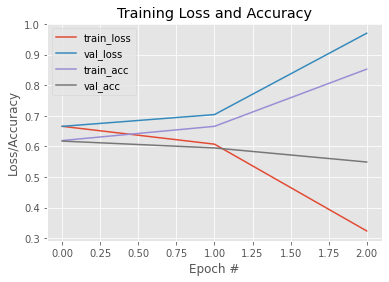

In [38]:
plt.style.use('ggplot')
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='best')

In [39]:
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

286/286 [==============================] - 0s 337us/step
Test score: 0.9764041504659853
Test accuracy: 0.5279720425605774


In [0]:
%rm keras.h5
model.save('keras.h5')